## Sentimental Analysis on a Review Dataset using Embedding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from tqdm.notebook import tqdm

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/soumyajit4419/Deep_Learning_Projects/master/NLP_With_PyTorch/Dataset/feedback%20dataset.csv')
df.head()

,text,sentiment
0,Display is excellent and camera is as good as ...,1
1,Battery life is also great!,1
2,Protects the phone on all sides.,1
3,"Clear Skype Calls, Long Battery Life, Long Range.",1
4,Great Hands Free Device.,1


In [5]:
df.shape

(5200, 2)

In [6]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [7]:
# Cleaning the text
wordnet  = WordNetLemmatizer()
def clean_text(text):
  text = re.sub('[^a-zA-Z]',' ',text)
  text = text.lower()
  text = text.split(' ')
  text = [wordnet.lemmatize(word) for word in text if word not in stopwords.words('english')]
  text = ' '.join(text)
  return text

In [8]:
df['cleaned_text'] = df['text'].apply(clean_text)

In [9]:
# Creating Tokens
vectorizer = CountVectorizer()
vectorizer.fit(df['cleaned_text'])

token2idx = vectorizer.vocabulary_
token2idx['UNK'] = max(token2idx.values())+1

idx2token = {idx:token for token,idx in token2idx.items()}

In [10]:
vocab_size = len(token2idx)
vocab_size

4910

In [11]:
# Encode the sentence into numbers
def encode(text,max_len=30):
  text = text.strip()
  text = text.split(' ')
  encoded = np.zeros(max_len,dtype=int)
  enc = [token2idx.get(word,token2idx['UNK']) for word in text] 
  length = min(max_len,len(enc))
  encoded[:length] = enc[:length]
  return encoded

In [12]:
df['encoded'] = df['cleaned_text'].apply(encode)

In [13]:
df.head()

,text,sentiment,cleaned_text,encoded
0,Display is excellent and camera is as good as ...,1,display excellent camera good year,"[1207, 1490, 578, 1873, 4888, 0, 0, 0, 0, 0, 0..."
1,Battery life is also great!,1,battery life also great,"[345, 2498, 128, 1903, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Protects the phone on all sides.,1,protects phone side,"[3356, 3168, 3900, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"Clear Skype Calls, Long Battery Life, Long Range.",1,clear skype call long battery life long range,"[742, 3940, 571, 4909, 2548, 345, 2498, 4909, ..."
4,Great Hands Free Device.,1,great hand free device,"[1903, 1955, 1751, 1141, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
inputs = torch.tensor(df['encoded'],dtype=torch.long)
target = torch.tensor(df['sentiment'].values,dtype=torch.float)

In [15]:
# Dataset and Dataloader
dataset = TensorDataset(inputs,target)

val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

train_loader = DataLoader(train_ds,batch_size=128,shuffle=True,num_workers=3,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=128,shuffle=True,num_workers=3,pin_memory=True)

In [16]:
# Using GPU device if available
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()
device

device(type='cuda')

In [46]:
# Defining  a model
class Sentimental_Analysis(nn.Module):

  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,100)
    self.lstm = nn.GRU(100,256,num_layers=1,batch_first=True)
    self.linear = nn.Linear(256,1)

  def forward(self,xb):
    batch_size = xb.size(0)
    out = self.embedding(xb)
    out,state = self.lstm(out)
    # out = out.contiguous().view(-1,256)
    # out = self.linear(out)
    # out = F.sigmoid(out)
    # out = out.view(batch_size, -1)
    # out = out[:, -1]
    return out

In [47]:
model = Sentimental_Analysis()

In [34]:
model

Sentimental_Analysis(
  (embedding): Embedding(4910, 100)
  (lstm): GRU(100, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [49]:
# for data,_ in train_loader:
#   out = model(data)
#   break

In [50]:
# out.shape

In [27]:
# Moving the model to gpu
model = model.to(device)

In [28]:
# Function to get accuracy
def accuracy(pred,target):
  rounded_preds = torch.round(pred)
  correct = (rounded_preds == target).float() 
  acc = correct.sum() / len(correct)
  return acc

# Checking the validation loss and validation accuracy
def evaluate(model):
  model.eval()
  losses = []
  accuracies = []
  for input,target in val_loader:
    input = input.to(device)
    target = target.to(device)
    out = model(input)
    loss = F.binary_cross_entropy(out,target)
    acc = accuracy(out,target)
    accuracies.append(acc)
    losses.append(loss)
  return torch.stack(losses).mean().item(), torch.stack(accuracies).mean().item()

In [29]:
# Training the model for some number of epochs
def fit(num_epochs):
  train_losses = []
  val_losses = []
  val_accs = []
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  for epoch in range(num_epochs):
    model.train()
    losses = []
    for input,target in tqdm(train_loader):
       
      input = input.to(device)
      target = target.to(device)
      
      input = input.long()
      target = target.float()

      out = model(input)
      loss = F.binary_cross_entropy(out,target)
      loss.backward()
      optimizer.step()
      losses.append(loss)
      optimizer.zero_grad()
    train_loss = torch.stack(losses).mean().item()
    val_loss,val_acc = evaluate(model)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
  
    print("Epoch: {}, train_loss: {}, val_loss: {}, val_acc: {}".format(epoch+1,train_loss,val_loss,val_acc))
  return train_losses,val_losses,val_accs

In [30]:
history = fit(15)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch: 1, train_loss: 0.6944786906242371, val_loss: 0.6901429295539856, val_acc: 0.5104166865348816



Epoch: 2, train_loss: 0.6497517228126526, val_loss: 0.6291475296020508, val_acc: 0.6779513955116272



Epoch: 3, train_loss: 0.5250201225280762, val_loss: 0.5318408608436584, val_acc: 0.7482638955116272



Epoch: 4, train_loss: 0.44491833448410034, val_loss: 0.5384214520454407, val_acc: 0.7387152910232544



Epoch: 5, train_loss: 0.36717677116394043, val_loss: 0.5046355724334717, val_acc: 0.7829861044883728



Epoch: 6, train_loss: 0.29647573828697205, val_loss: 0.45126110315322876, val_acc: 0.8298611044883728



Epoch: 7, train_loss: 0.2404637336730957, val_loss: 0.4915675222873688, val_acc: 0.8255208134651184



Epoch: 8, train_loss: 0.1944240927696228, val_loss: 0.5205222368240356, val_acc: 0.8177083134651184



Epoch: 9, train_loss: 0.15202081203460693, val_loss: 0.5065819025039673, val_acc: 0.8203125



Epoch: 10, train_loss: 0.13824838399887085, val_loss: 0.553579568862915, val_acc: 0.8385416865348816



Epoch: 11, train_loss: 0.11217176169157028, val_loss: 0.5445114970207214, val_acc: 0.8315972089767456



Epoch: 12, train_loss: 0.10297030955553055, val_loss: 0.5046473741531372, val_acc: 0.8359375



Epoch: 13, train_loss: 0.09361108392477036, val_loss: 0.576573371887207, val_acc: 0.8237847089767456



Epoch: 14, train_loss: 0.08000585436820984, val_loss: 0.6221821904182434, val_acc: 0.8472222089767456



Epoch: 15, train_loss: 0.08905061334371567, val_loss: 0.6048881411552429, val_acc: 0.8159722089767456


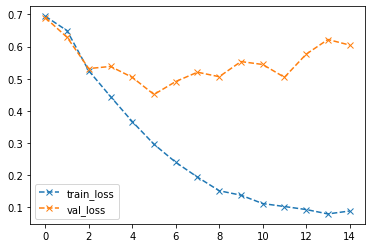

In [31]:
# Plotting the losses 
train_losses,val_losses,val_acc = history 
plt.plot(train_losses,label='train_loss',linestyle='--', marker='x')
plt.plot(val_losses,label='val_loss',linestyle='--',marker='x')
plt.legend()
plt.show()